# Overview

**GENERAL THOUGHTS:**  
This notebook includes the following scenarios for Decision Tree Classifier performance evaluation.
- Decision Tree pipeline without overs


**CUSTOM DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

numeric data:
- data imputation: SimpleImputer(strategy='median')
- data scaling: PowerTransformer() using 'log_transform'

categorical data:
- data imputation: SimpleImputer(strategy='most_frequent')
- categorical data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)


**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# import lightgbm as lgbm

import optuna
# from optuna.samplers import TPESampler

import imblearn
from imblearn.over_sampling import RandomOverSampler

# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform

# import custom functions
import sys
sys.path.append('/Users/dat/Library/CloudStorage/OneDrive-foryouandyourcustomers/GitHub/AutomatedPackagingCategories_Showcase/ml_packaging_classification/src')
import utils

import warnings
warnings.filterwarnings('ignore') # 'default'

/Users/dat/miniconda3/envs/py_ml_packaging_classification/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42

# Load data

In [4]:
df = pd.read_csv('../../data/output/df_ml.csv', sep='\t')

# Prep data for machine learning

## Clean data

In [5]:
df['material_number'] = df['material_number'].astype('object')

df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         82977 non-null  object 
 1   material_number_text    82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   component_text          82977 non-null  object 
 7   manufactoring_location  82977 non-null  object 
 8   characteristic_value    82977 non-null  object 
 9   material_weight         75913 non-null  float64
 10  packaging_code          82977 non-null  object 
 11  packaging_category      82977 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


## Split data into train/test

In [6]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [7]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

# DecisionTree pipeline without oversampling

## DecisionTree (without HPO)

In [8]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
# y_train_transformed = label_ecoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# DEFINE MODEL PIPELINE
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)

# Training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.3272337383845604,
                                     1: 0.36161137440758295, 2: 286.125,
                                     3: 4.231053604436229, 4: 7.153125,
                                     5: 4.385057471264368, 6: 65.4,
                                     7: 5.899484536082475,
                                     8: 0.7388637830858619, 9: 19.075,
                                     10: 9.69915254237288, 11: 190.75,
                                     12: 0.34813688212927757,
                                     13: 0.21127930588886837, 14: 57.225,
                                     15: 0.8227893601725378,
                                     16: 1.9186923721709974,
                                     17: 1.6756954612005857,
                                     18: 1.5029546946815495,
                                     19: 1.5466216216216215,
                                     20: 1.9090909090909092,
                                     21: 2.5043763676148796,
                                     22: 0.34488473708000605,
                                     23: 3.5598755832037323, 24: 1.308,
                                     25: 6.6347826086956525,
                                     26: 0.24481283422459893,
                                     27: 2.0220848056537104,
                                     28: 176.07692307692307})

In [9]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

y_test_transformed = label_encoder.transform(y_test)
preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", dt_clf.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", dt_clf.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  1.0
Test score (f1-score):  0.7528922631959508
                            precision    recall  f1-score   support

   Blister and Insert Card       0.67      0.74      0.70      1749
  Blister and sealed blist       0.77      0.71      0.74      1582
            Book packaging       1.00      0.50      0.67         2
Cardb. Sleeve w - w/o Shr.       0.57      0.53      0.55       135
  Cardboard hanger w/o bag       0.44      0.35      0.39        80
    Carton cover (Lid box)       0.57      0.52      0.54       130
   Carton tube with or w/o       0.00      0.00      0.00         9
                      Case       0.32      0.48      0.39        97
         Corrugated carton       0.74      0.71      0.73       774
        Countertop display       0.65      0.43      0.52        30
                  Envelope       0.80      0.81      0.81        59
          Fabric packaging       0.00      0.00      0.00         3
            Folding carton       0.73      

## DecisionTree HPO

### Performe HPO

In [10]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_dt_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_dt_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [11]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: RandomSampler
# study = optuna.create_study(direction="maximize", sampler=optuna.RandomSampler(seed=SEED))
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="dt_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=60,
    # timeout=600, 
    show_progress_bar=True
)

[I 2024-01-25 17:01:57,259] A new study created in memory with name: dt_optuna
Best trial: 0. Best value: 0.600439:   2%|▏         | 1/60 [00:00<00:17,  3.31it/s]

[I 2024-01-25 17:01:57,577] Trial 0 finished with value: 0.6004389447577525 and parameters: {'max_depth': 50, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6004389447577525.


Best trial: 0. Best value: 0.600439:   3%|▎         | 2/60 [00:00<00:15,  3.84it/s]

[I 2024-01-25 17:01:57,808] Trial 1 finished with value: 0.5883120506870282 and parameters: {'max_depth': 28, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.6004389447577525.


Best trial: 0. Best value: 0.600439:   7%|▋         | 4/60 [00:00<00:10,  5.28it/s]

[I 2024-01-25 17:01:58,029] Trial 2 finished with value: 0.5552019830790489 and parameters: {'max_depth': 100, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.6004389447577525.
[I 2024-01-25 17:01:58,138] Trial 3 finished with value: 0.07940609498532115 and parameters: {'max_depth': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.6004389447577525.


Best trial: 0. Best value: 0.600439:   8%|▊         | 5/60 [00:01<00:11,  4.97it/s]

[I 2024-01-25 17:01:58,359] Trial 4 finished with value: 0.5547764249735274 and parameters: {'max_depth': 32, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.6004389447577525.


Best trial: 5. Best value: 0.64603:  10%|█         | 6/60 [00:01<00:12,  4.43it/s] 

[I 2024-01-25 17:01:58,633] Trial 5 finished with value: 0.6460295323313808 and parameters: {'max_depth': 100, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 5 with value: 0.6460295323313808.


Best trial: 5. Best value: 0.64603:  12%|█▏        | 7/60 [00:01<00:12,  4.23it/s]

[I 2024-01-25 17:01:58,892] Trial 6 finished with value: 0.6330681427362707 and parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 5 with value: 0.6460295323313808.


Best trial: 5. Best value: 0.64603:  13%|█▎        | 8/60 [00:01<00:12,  4.25it/s]

[I 2024-01-25 17:01:59,125] Trial 7 finished with value: 0.6066005824533733 and parameters: {'max_depth': 80, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 5 with value: 0.6460295323313808.


Best trial: 5. Best value: 0.64603:  17%|█▋        | 10/60 [00:02<00:11,  4.40it/s]

[I 2024-01-25 17:01:59,389] Trial 8 finished with value: 0.5663476377841282 and parameters: {'max_depth': 40, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 5 with value: 0.6460295323313808.
[I 2024-01-25 17:01:59,579] Trial 9 finished with value: 0.4759500263307661 and parameters: {'max_depth': 12, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 5 with value: 0.6460295323313808.


Best trial: 10. Best value: 0.668461:  18%|█▊        | 11/60 [00:02<00:12,  4.07it/s]

[I 2024-01-25 17:01:59,865] Trial 10 finished with value: 0.6684605810372789 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  22%|██▏       | 13/60 [00:03<00:10,  4.62it/s]

[I 2024-01-25 17:02:00,181] Trial 11 finished with value: 0.6253330768022388 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.
[I 2024-01-25 17:02:00,281] Trial 12 finished with value: 0.047667546957871294 and parameters: {'max_depth': 2, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  23%|██▎       | 14/60 [00:03<00:09,  4.74it/s]

[I 2024-01-25 17:02:00,479] Trial 13 finished with value: 0.364755549114739 and parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  25%|██▌       | 15/60 [00:03<00:10,  4.28it/s]

[I 2024-01-25 17:02:00,766] Trial 14 finished with value: 0.6445304622479856 and parameters: {'max_depth': 24, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  27%|██▋       | 16/60 [00:03<00:10,  4.07it/s]

[I 2024-01-25 17:02:01,039] Trial 15 finished with value: 0.5892988909440713 and parameters: {'max_depth': 36, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  28%|██▊       | 17/60 [00:04<00:11,  3.91it/s]

[I 2024-01-25 17:02:01,319] Trial 16 finished with value: 0.6190863419393591 and parameters: {'max_depth': 100, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  30%|███       | 18/60 [00:04<00:10,  3.82it/s]

[I 2024-01-25 17:02:01,595] Trial 17 finished with value: 0.6052893011587355 and parameters: {'max_depth': 20, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  32%|███▏      | 19/60 [00:04<00:10,  3.76it/s]

[I 2024-01-25 17:02:01,871] Trial 18 finished with value: 0.5912090931038643 and parameters: {'max_depth': 60, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  33%|███▎      | 20/60 [00:04<00:10,  3.64it/s]

[I 2024-01-25 17:02:02,165] Trial 19 finished with value: 0.6341565799773433 and parameters: {'max_depth': 100, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  35%|███▌      | 21/60 [00:05<00:10,  3.59it/s]

[I 2024-01-25 17:02:02,453] Trial 20 finished with value: 0.6425714771759496 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  37%|███▋      | 22/60 [00:05<00:10,  3.56it/s]

[I 2024-01-25 17:02:02,740] Trial 21 finished with value: 0.62655376923941 and parameters: {'max_depth': 24, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  38%|███▊      | 23/60 [00:05<00:10,  3.49it/s]

[I 2024-01-25 17:02:03,038] Trial 22 finished with value: 0.6372924385151685 and parameters: {'max_depth': 24, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  40%|████      | 24/60 [00:06<00:10,  3.50it/s]

[I 2024-01-25 17:02:03,323] Trial 23 finished with value: 0.5977402496920408 and parameters: {'max_depth': 24, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  42%|████▏     | 25/60 [00:06<00:09,  3.55it/s]

[I 2024-01-25 17:02:03,595] Trial 24 finished with value: 0.6385077864092968 and parameters: {'max_depth': 32, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  43%|████▎     | 26/60 [00:06<00:09,  3.49it/s]

[I 2024-01-25 17:02:03,893] Trial 25 finished with value: 0.6454077981054664 and parameters: {'max_depth': 80, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  45%|████▌     | 27/60 [00:06<00:09,  3.50it/s]

[I 2024-01-25 17:02:04,178] Trial 26 finished with value: 0.6178876860406257 and parameters: {'max_depth': 80, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  47%|████▋     | 28/60 [00:07<00:09,  3.53it/s]

[I 2024-01-25 17:02:04,454] Trial 27 finished with value: 0.5940390443828414 and parameters: {'max_depth': 80, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  50%|█████     | 30/60 [00:07<00:07,  3.89it/s]

[I 2024-01-25 17:02:04,735] Trial 28 finished with value: 0.6356230421567288 and parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.
[I 2024-01-25 17:02:04,933] Trial 29 finished with value: 0.3265208414688352 and parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  52%|█████▏    | 31/60 [00:07<00:07,  3.81it/s]

[I 2024-01-25 17:02:05,208] Trial 30 finished with value: 0.6187099814353327 and parameters: {'max_depth': 50, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  53%|█████▎    | 32/60 [00:08<00:07,  3.68it/s]

[I 2024-01-25 17:02:05,503] Trial 31 finished with value: 0.6560257522800651 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  55%|█████▌    | 33/60 [00:08<00:07,  3.60it/s]

[I 2024-01-25 17:02:05,794] Trial 32 finished with value: 0.647849558718733 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  57%|█████▋    | 34/60 [00:08<00:07,  3.57it/s]

[I 2024-01-25 17:02:06,080] Trial 33 finished with value: 0.6336711854789406 and parameters: {'max_depth': 28, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  58%|█████▊    | 35/60 [00:09<00:06,  3.67it/s]

[I 2024-01-25 17:02:06,333] Trial 34 finished with value: 0.6410876020139423 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  60%|██████    | 36/60 [00:09<00:06,  3.80it/s]

[I 2024-01-25 17:02:06,574] Trial 35 finished with value: 0.6645798506257432 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  62%|██████▏   | 37/60 [00:09<00:05,  3.88it/s]

[I 2024-01-25 17:02:06,819] Trial 36 finished with value: 0.6365962113717516 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  63%|██████▎   | 38/60 [00:09<00:05,  4.03it/s]

[I 2024-01-25 17:02:07,045] Trial 37 finished with value: 0.5502591304513446 and parameters: {'max_depth': 28, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  67%|██████▋   | 40/60 [00:10<00:04,  4.85it/s]

[I 2024-01-25 17:02:07,269] Trial 38 finished with value: 0.5786852565245407 and parameters: {'max_depth': 28, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.
[I 2024-01-25 17:02:07,395] Trial 39 finished with value: 0.11804562349424066 and parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  68%|██████▊   | 41/60 [00:10<00:04,  4.75it/s]

[I 2024-01-25 17:02:07,616] Trial 40 finished with value: 0.5294215718719248 and parameters: {'max_depth': 16, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  70%|███████   | 42/60 [00:10<00:04,  4.49it/s]

[I 2024-01-25 17:02:07,866] Trial 41 finished with value: 0.6422387479331968 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  72%|███████▏  | 43/60 [00:10<00:04,  4.17it/s]

[I 2024-01-25 17:02:08,145] Trial 42 finished with value: 0.6234399260680198 and parameters: {'max_depth': 40, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  73%|███████▎  | 44/60 [00:11<00:03,  4.37it/s]

[I 2024-01-25 17:02:08,350] Trial 43 finished with value: 0.45036217154697833 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  75%|███████▌  | 45/60 [00:11<00:03,  4.02it/s]

[I 2024-01-25 17:02:08,644] Trial 44 finished with value: 0.6384071839261717 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.
[I 2024-01-25 17:02:08,744] Trial 45 finished with value: 0.04996861466218082 and parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  78%|███████▊  | 47/60 [00:11<00:02,  4.70it/s]

[I 2024-01-25 17:02:08,985] Trial 46 finished with value: 0.6429143037630588 and parameters: {'max_depth': 36, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  80%|████████  | 48/60 [00:11<00:02,  4.37it/s]

[I 2024-01-25 17:02:09,263] Trial 47 finished with value: 0.5889002187185883 and parameters: {'max_depth': 28, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  82%|████████▏ | 49/60 [00:12<00:02,  4.07it/s]

[I 2024-01-25 17:02:09,556] Trial 48 finished with value: 0.62457592412463 and parameters: {'max_depth': 60, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  85%|████████▌ | 51/60 [00:12<00:01,  4.58it/s]

[I 2024-01-25 17:02:09,848] Trial 49 finished with value: 0.6392503675527713 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.
[I 2024-01-25 17:02:09,963] Trial 50 finished with value: 0.05530283406496982 and parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 10. Best value: 0.668461:  87%|████████▋ | 52/60 [00:12<00:01,  4.19it/s]

[I 2024-01-25 17:02:10,253] Trial 51 finished with value: 0.6494988956324432 and parameters: {'max_depth': 80, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.6684605810372789.


Best trial: 52. Best value: 0.673697:  88%|████████▊ | 53/60 [00:13<00:01,  3.97it/s]

[I 2024-01-25 17:02:10,538] Trial 52 finished with value: 0.6736970711690171 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 52 with value: 0.6736970711690171.


Best trial: 52. Best value: 0.673697:  90%|█████████ | 54/60 [00:13<00:01,  3.78it/s]

[I 2024-01-25 17:02:10,833] Trial 53 finished with value: 0.6438004412410596 and parameters: {'max_depth': 32, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 52 with value: 0.6736970711690171.


Best trial: 52. Best value: 0.673697:  92%|█████████▏| 55/60 [00:13<00:01,  3.66it/s]

[I 2024-01-25 17:02:11,126] Trial 54 finished with value: 0.6548367739368633 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 52 with value: 0.6736970711690171.


Best trial: 55. Best value: 0.68244:  93%|█████████▎| 56/60 [00:14<00:01,  3.55it/s] 

[I 2024-01-25 17:02:11,429] Trial 55 finished with value: 0.6824397585469382 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 55 with value: 0.6824397585469382.


Best trial: 55. Best value: 0.68244:  95%|█████████▌| 57/60 [00:14<00:00,  3.45it/s]

[I 2024-01-25 17:02:11,739] Trial 56 finished with value: 0.6472476292046416 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 55 with value: 0.6824397585469382.


Best trial: 55. Best value: 0.68244:  97%|█████████▋| 58/60 [00:14<00:00,  3.47it/s]

[I 2024-01-25 17:02:12,022] Trial 57 finished with value: 0.6226183275084601 and parameters: {'max_depth': 50, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 55 with value: 0.6824397585469382.


Best trial: 55. Best value: 0.68244:  98%|█████████▊| 59/60 [00:15<00:00,  3.45it/s]

[I 2024-01-25 17:02:12,315] Trial 58 finished with value: 0.6666195320895092 and parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 55 with value: 0.6824397585469382.


Best trial: 55. Best value: 0.68244: 100%|██████████| 60/60 [00:15<00:00,  3.92it/s]

[I 2024-01-25 17:02:12,595] Trial 59 finished with value: 0.5789770089944397 and parameters: {'max_depth': 50, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 55 with value: 0.6824397585469382.


In [12]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  60
Best trial:
  Performance:  0.6824397585469382
  Best trial: {'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}


### Analyse HPO
Auswertung Optuna study

In [13]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_leaf,state
0,0,0.600439,2024-01-25 17:01:57.277846,2024-01-25 17:01:57.577617,0 days 00:00:00.299771,entropy,50,2,COMPLETE
1,1,0.588312,2024-01-25 17:01:57.579322,2024-01-25 17:01:57.808837,0 days 00:00:00.229515,gini,28,8,COMPLETE
2,2,0.555202,2024-01-25 17:01:57.810700,2024-01-25 17:01:58.029281,0 days 00:00:00.218581,gini,100,7,COMPLETE
3,3,0.079406,2024-01-25 17:01:58.030983,2024-01-25 17:01:58.138010,0 days 00:00:00.107027,gini,4,8,COMPLETE
4,4,0.554776,2024-01-25 17:01:58.139569,2024-01-25 17:01:58.359496,0 days 00:00:00.219927,gini,32,6,COMPLETE


In [14]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [15]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [16]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [18]:
best_trial.params

{'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}

In [19]:
# Define best model

best_params = best_trial.params
# best_params = {
#     'max_depth': 50,
#     'criterion': 'entropy'
# }

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [20]:
#
performance_train, performance_test, kf = utils.check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_encoder=label_encoder,
    # random_state=SEED
)

mean train performance: 0.9986640782948808
mean test performance: 0.5888799533660733


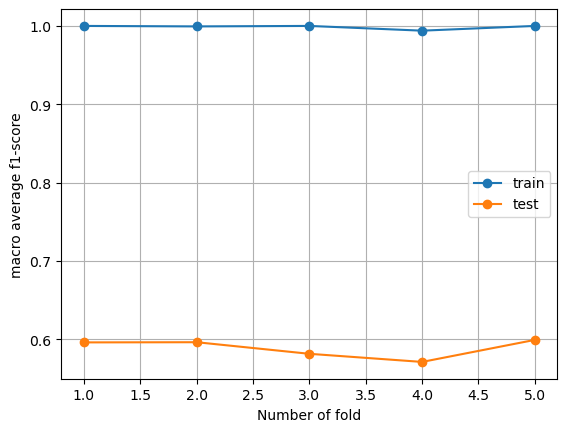

In [21]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='C0', label='train')
plt.plot(folds, performance_test, 'o-', color='C1', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('macro average f1-score')
plt.show()

In [22]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

print(classification_report(y_test, preds_y_test_inverse))

                            precision    recall  f1-score   support

   Blister and Insert Card       0.61      0.71      0.65      1749
  Blister and sealed blist       0.40      0.17      0.24      1582
            Book packaging       0.00      0.00      0.00         2
Cardb. Sleeve w - w/o Shr.       0.26      0.39      0.31       135
  Cardboard hanger w/o bag       0.53      0.50      0.51        80
    Carton cover (Lid box)       0.07      0.02      0.03       130
   Carton tube with or w/o       0.00      0.00      0.00         9
                      Case       0.44      0.46      0.45        97
         Corrugated carton       0.57      0.56      0.57       774
        Countertop display       0.01      0.47      0.02        30
                  Envelope       0.77      0.73      0.75        59
          Fabric packaging       0.00      0.00      0.00         3
            Folding carton       0.49      0.67      0.57      1644
              Hanger/ Clip       0.80      0.81

### Deeper analysis of DecisionTreeClassifier

In [23]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,TightPack,TightPack,1.0
1,Hanger/ Clip,Hanger/ Clip,1.0
2,Tube,Tube,1.0
3,Blister and Insert Card,Folding carton,1.0
4,Blister and sealed blist,Blister and Insert Card,1.0
5,Blister and sealed blist,Countertop display,1.0
6,TightPack,TightPack,1.0
7,Shrink film and insert o,Shrink film and insert o,1.0
8,Hanger/ Clip,Hanger/ Clip,1.0
9,Blister and sealed blist,Folding carton,1.0


In [24]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test


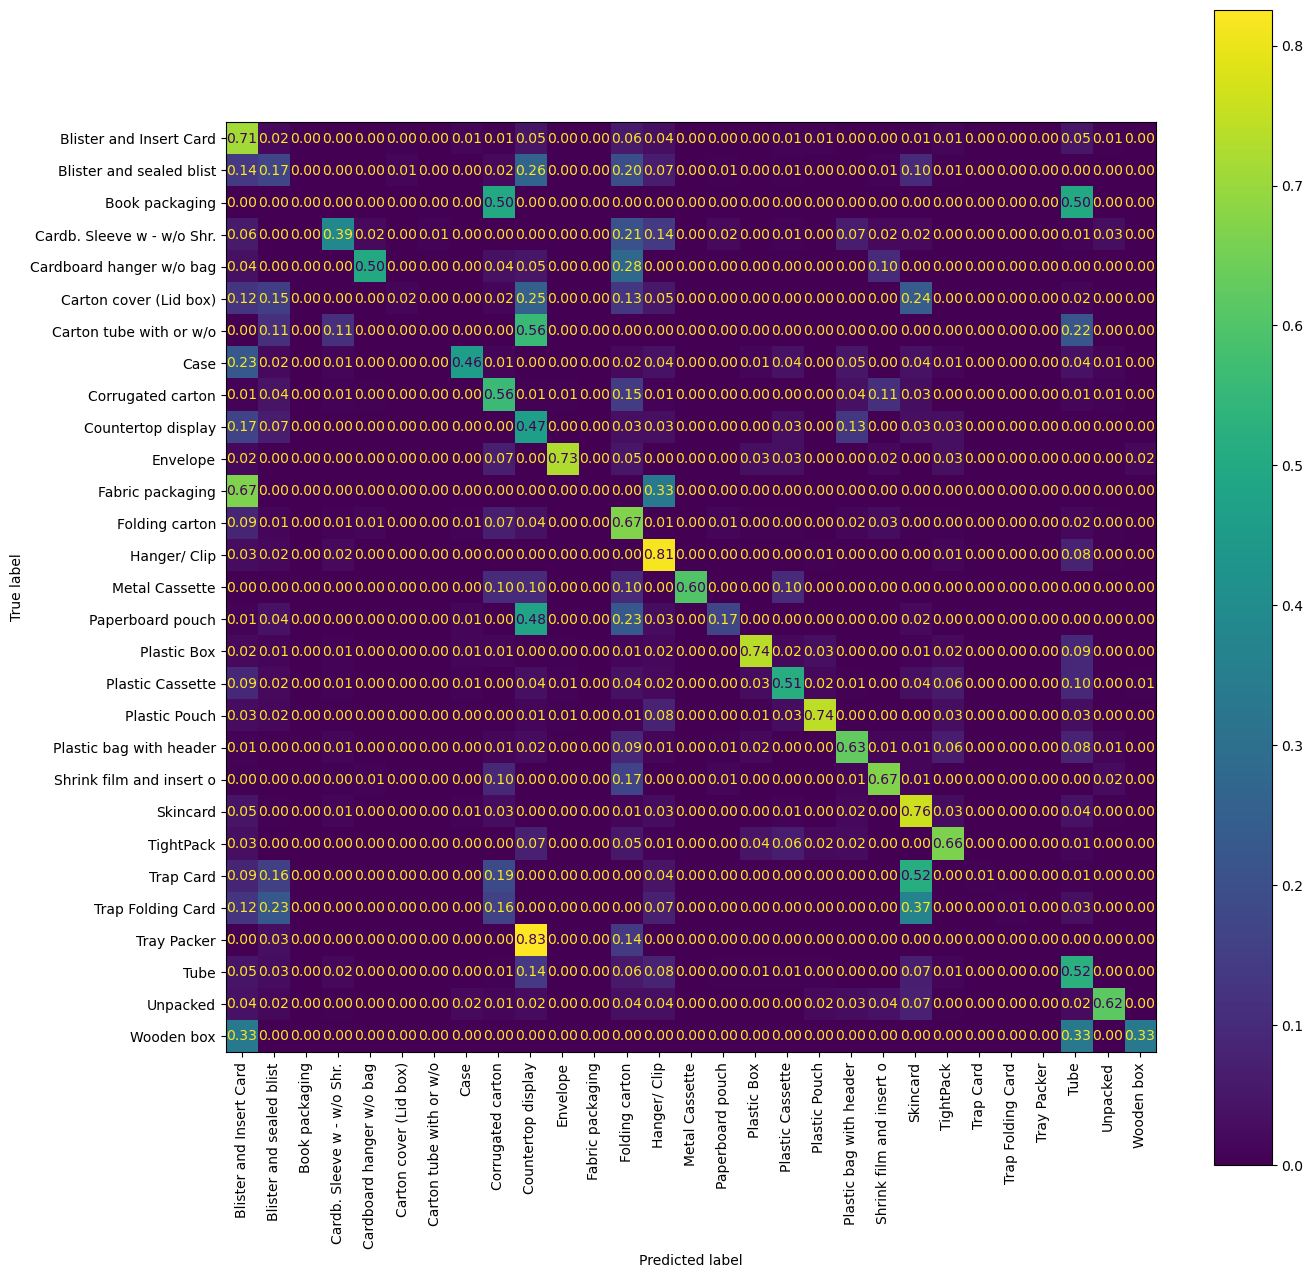

In [25]:
# Create the confusion matrix
# confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

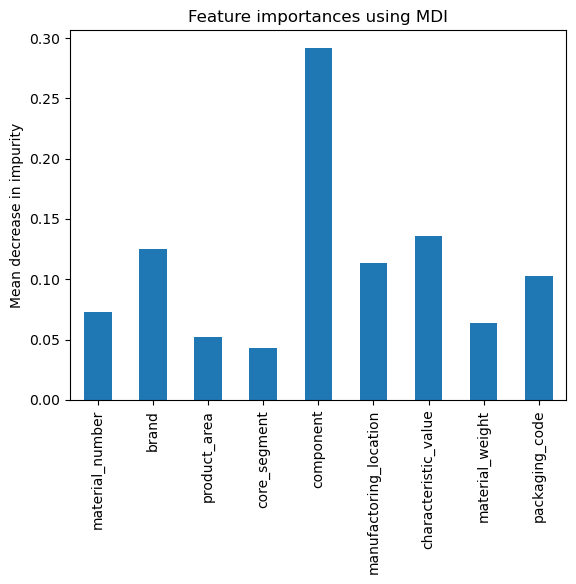

In [26]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# DecisionTree pipeline with oversampling

<Figure size 1000x500 with 0 Axes>

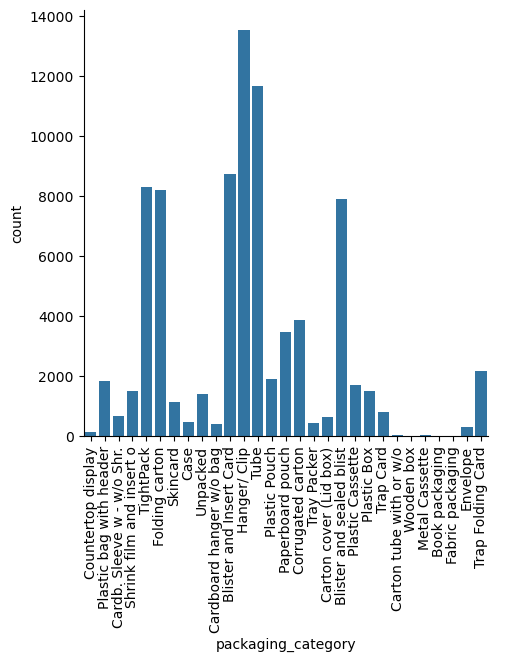

In [27]:
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_sub,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

In [28]:
distribution_classes = y.value_counts()
print('Class distribution before oversmapling')
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'Metal Cassette': 100,
    'Carton tube with or w/o': 100,
    'Wooden box': 100,
    'Fabric packaging': 100,
    'Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X, y = oversampler.fit_resample(X, y)

distribution_classes = y.value_counts()
print('\n')
print('Class distribution after oversampling')
print(distribution_classes.to_dict())

Class distribution before oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap Folding Card': 2188, 'Plastic Pouch': 1904, 'Plastic bag with header': 1850, 'Plastic Cassette': 1708, 'Shrink film and insert o': 1499, 'Plastic Box': 1491, 'Unpacked': 1415, 'Skincard': 1143, 'Trap Card': 804, 'Cardb. Sleeve w - w/o Shr.': 676, 'Carton cover (Lid box)': 652, 'Case': 485, 'Tray Packer': 431, 'Cardboard hanger w/o bag': 400, 'Envelope': 295, 'Countertop display': 150, 'Metal Cassette': 50, 'Carton tube with or w/o': 44, 'Wooden box': 16, 'Fabric packaging': 15, 'Book packaging': 10}


Class distribution after oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap 

In [29]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

## DecisionTree (without HPO)

In [30]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on separate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# DEFINE MODEL PIPELINE
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)

# Training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.3286731902097557,
                                     1: 0.36320204826496705,
                                     2: 28.738362068965518,
                                     3: 4.249665370641851,
                                     4: 7.1845905172413795,
                                     5: 4.404346677236094,
                                     6: 28.738362068965518, 7: 5.92543547813722,
                                     8: 0.7421139333496583,
                                     9: 19.15890804597701,
                                     10: 9.741817650496786,
                                     11: 28.738362068965518,
                                     12: 0.349668283728858,
                                     13: 0.2122086916667197,
                                     14: 28.738362068965518,
                                     15: 0.8264086863829049,
                                     16: 1.9271324103245946,
                                     17: 1.6830665926187711,
                                     18: 1.5095659655398828,
                                     19: 1.5534249767008388,
                                     20: 1.9174887118575825,
                                     21: 2.5153927412661283,
                                     22: 0.34640183298436666,
                                     23: 3.5755349385960207,
                                     24: 1.3137536945812809,
                                     25: 6.663968015992004,
                                     26: 0.24588972893232527,
                                     27: 2.0309796515169976,
                                     28: 28.738362068965518})

In [31]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

y_test_transformed = label_encoder.transform(y_test)
preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", dt_clf.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", dt_clf.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  1.0
Test score (f1-score):  0.7428160057591937
                            precision    recall  f1-score   support

   Blister and Insert Card       0.69      0.72      0.71      1749
  Blister and sealed blist       0.73      0.67      0.70      1582
            Book packaging       1.00      1.00      1.00        20
Cardb. Sleeve w - w/o Shr.       0.38      0.40      0.39       135
  Cardboard hanger w/o bag       0.38      0.33      0.35        80
    Carton cover (Lid box)       0.51      0.51      0.51       130
   Carton tube with or w/o       0.83      0.95      0.88        20
                      Case       0.11      0.51      0.19        97
         Corrugated carton       0.74      0.73      0.74       774
        Countertop display       0.68      0.63      0.66        30
                  Envelope       0.88      0.85      0.86        59
          Fabric packaging       1.00      1.00      1.00        20
            Folding carton       0.71      

## DecisionTree HPO

### Performe HPO

In [32]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_dt_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_dt_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [33]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: RandomSampler
# study = optuna.create_study(direction="maximize", sampler=optuna.RandomSampler(seed=SEED))
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="dt_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=60,
    # timeout=600, 
    show_progress_bar=True
)

[I 2024-01-25 17:02:19,416] A new study created in memory with name: dt_optuna
Best trial: 0. Best value: 0.736449:   2%|▏         | 1/60 [00:00<00:17,  3.33it/s]

[I 2024-01-25 17:02:19,716] Trial 0 finished with value: 0.7364490870119499 and parameters: {'max_depth': 50, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7364490870119499.


Best trial: 0. Best value: 0.736449:   3%|▎         | 2/60 [00:00<00:15,  3.78it/s]

[I 2024-01-25 17:02:19,956] Trial 1 finished with value: 0.6688637781801536 and parameters: {'max_depth': 28, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.7364490870119499.


Best trial: 0. Best value: 0.736449:   7%|▋         | 4/60 [00:00<00:10,  5.24it/s]

[I 2024-01-25 17:02:20,177] Trial 2 finished with value: 0.669327010710816 and parameters: {'max_depth': 100, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.7364490870119499.
[I 2024-01-25 17:02:20,285] Trial 3 finished with value: 0.07979756301579619 and parameters: {'max_depth': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.7364490870119499.


Best trial: 0. Best value: 0.736449:   8%|▊         | 5/60 [00:01<00:11,  4.87it/s]

[I 2024-01-25 17:02:20,516] Trial 4 finished with value: 0.6462276258638049 and parameters: {'max_depth': 32, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.7364490870119499.


Best trial: 5. Best value: 0.736456:  10%|█         | 6/60 [00:01<00:12,  4.34it/s]

[I 2024-01-25 17:02:20,796] Trial 5 finished with value: 0.736455631564515 and parameters: {'max_depth': 100, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 5 with value: 0.736455631564515.


Best trial: 5. Best value: 0.736456:  12%|█▏        | 7/60 [00:01<00:12,  4.13it/s]

[I 2024-01-25 17:02:21,062] Trial 6 finished with value: 0.7363074213244093 and parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 5 with value: 0.736455631564515.


Best trial: 5. Best value: 0.736456:  13%|█▎        | 8/60 [00:01<00:12,  4.15it/s]

[I 2024-01-25 17:02:21,301] Trial 7 finished with value: 0.6948530002671566 and parameters: {'max_depth': 80, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 5 with value: 0.736455631564515.


Best trial: 5. Best value: 0.736456:  17%|█▋        | 10/60 [00:02<00:11,  4.30it/s]

[I 2024-01-25 17:02:21,570] Trial 8 finished with value: 0.6508943605581337 and parameters: {'max_depth': 40, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 5 with value: 0.736455631564515.
[I 2024-01-25 17:02:21,763] Trial 9 finished with value: 0.529276356550533 and parameters: {'max_depth': 12, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 5 with value: 0.736455631564515.


Best trial: 10. Best value: 0.756081:  18%|█▊        | 11/60 [00:02<00:12,  3.92it/s]

[I 2024-01-25 17:02:22,070] Trial 10 finished with value: 0.756080585634629 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.756080585634629.


Best trial: 10. Best value: 0.756081:  22%|██▏       | 13/60 [00:03<00:10,  4.61it/s]

[I 2024-01-25 17:02:22,364] Trial 11 finished with value: 0.7541696134402777 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.756080585634629.
[I 2024-01-25 17:02:22,467] Trial 12 finished with value: 0.0457755783039931 and parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 10 with value: 0.756080585634629.


Best trial: 10. Best value: 0.756081:  23%|██▎       | 14/60 [00:03<00:09,  4.72it/s]

[I 2024-01-25 17:02:22,666] Trial 13 finished with value: 0.33380703496071995 and parameters: {'max_depth': 8, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 10 with value: 0.756080585634629.


Best trial: 14. Best value: 0.762549:  25%|██▌       | 15/60 [00:03<00:10,  4.26it/s]

[I 2024-01-25 17:02:22,954] Trial 14 finished with value: 0.7625490592963305 and parameters: {'max_depth': 24, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 14 with value: 0.7625490592963305.


Best trial: 14. Best value: 0.762549:  27%|██▋       | 16/60 [00:03<00:10,  4.04it/s]

[I 2024-01-25 17:02:23,232] Trial 15 finished with value: 0.689227786930451 and parameters: {'max_depth': 24, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 14 with value: 0.7625490592963305.


Best trial: 14. Best value: 0.762549:  28%|██▊       | 17/60 [00:04<00:11,  3.88it/s]

[I 2024-01-25 17:02:23,513] Trial 16 finished with value: 0.7390622272389349 and parameters: {'max_depth': 60, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 14 with value: 0.7625490592963305.


Best trial: 14. Best value: 0.762549:  30%|███       | 18/60 [00:04<00:11,  3.80it/s]

[I 2024-01-25 17:02:23,788] Trial 17 finished with value: 0.7021248459130633 and parameters: {'max_depth': 20, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 14 with value: 0.7625490592963305.


Best trial: 14. Best value: 0.762549:  32%|███▏      | 19/60 [00:04<00:10,  3.77it/s]

[I 2024-01-25 17:02:24,060] Trial 18 finished with value: 0.6311783363188359 and parameters: {'max_depth': 24, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 14 with value: 0.7625490592963305.


Best trial: 14. Best value: 0.762549:  33%|███▎      | 20/60 [00:04<00:10,  3.66it/s]

[I 2024-01-25 17:02:24,352] Trial 19 finished with value: 0.7535626472258828 and parameters: {'max_depth': 36, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 14 with value: 0.7625490592963305.


Best trial: 14. Best value: 0.762549:  35%|███▌      | 21/60 [00:05<00:10,  3.64it/s]

[I 2024-01-25 17:02:24,629] Trial 20 finished with value: 0.7166786165597621 and parameters: {'max_depth': 24, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 14 with value: 0.7625490592963305.


Best trial: 21. Best value: 0.764536:  37%|███▋      | 22/60 [00:05<00:10,  3.60it/s]

[I 2024-01-25 17:02:24,914] Trial 21 finished with value: 0.7645364935017995 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  38%|███▊      | 23/60 [00:05<00:10,  3.52it/s]

[I 2024-01-25 17:02:25,212] Trial 22 finished with value: 0.7460457322014453 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  40%|████      | 24/60 [00:06<00:10,  3.43it/s]

[I 2024-01-25 17:02:25,521] Trial 23 finished with value: 0.7485402236013571 and parameters: {'max_depth': 100, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  42%|████▏     | 25/60 [00:06<00:10,  3.47it/s]

[I 2024-01-25 17:02:25,801] Trial 24 finished with value: 0.737383154165039 and parameters: {'max_depth': 60, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  43%|████▎     | 26/60 [00:06<00:09,  3.49it/s]

[I 2024-01-25 17:02:26,084] Trial 25 finished with value: 0.7641246433293413 and parameters: {'max_depth': 36, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  45%|████▌     | 27/60 [00:07<00:10,  3.25it/s]

[I 2024-01-25 17:02:26,440] Trial 26 finished with value: 0.7453075904250092 and parameters: {'max_depth': 36, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  47%|████▋     | 28/60 [00:07<00:09,  3.34it/s]

[I 2024-01-25 17:02:26,720] Trial 27 finished with value: 0.7203231026729606 and parameters: {'max_depth': 36, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  48%|████▊     | 29/60 [00:07<00:09,  3.37it/s]

[I 2024-01-25 17:02:27,012] Trial 28 finished with value: 0.7461141428379625 and parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  52%|█████▏    | 31/60 [00:07<00:06,  4.22it/s]

[I 2024-01-25 17:02:27,303] Trial 29 finished with value: 0.7075421366194973 and parameters: {'max_depth': 50, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.
[I 2024-01-25 17:02:27,405] Trial 30 finished with value: 0.038669646081877264 and parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  53%|█████▎    | 32/60 [00:08<00:07,  3.91it/s]

[I 2024-01-25 17:02:27,703] Trial 31 finished with value: 0.7636376841256024 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  55%|█████▌    | 33/60 [00:08<00:07,  3.67it/s]

[I 2024-01-25 17:02:28,015] Trial 32 finished with value: 0.7586955341891849 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  57%|█████▋    | 34/60 [00:08<00:07,  3.56it/s]

[I 2024-01-25 17:02:28,315] Trial 33 finished with value: 0.7181231699963321 and parameters: {'max_depth': 28, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  60%|██████    | 36/60 [00:09<00:05,  4.19it/s]

[I 2024-01-25 17:02:28,585] Trial 34 finished with value: 0.7567245874025751 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 21 with value: 0.7645364935017995.
[I 2024-01-25 17:02:28,741] Trial 35 finished with value: 0.11592203131726389 and parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  62%|██████▏   | 37/60 [00:09<00:05,  4.14it/s]

[I 2024-01-25 17:02:28,990] Trial 36 finished with value: 0.5781714339278807 and parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  63%|██████▎   | 38/60 [00:09<00:05,  4.06it/s]

[I 2024-01-25 17:02:29,248] Trial 37 finished with value: 0.6705259458418058 and parameters: {'max_depth': 32, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  65%|██████▌   | 39/60 [00:10<00:04,  4.21it/s]

[I 2024-01-25 17:02:29,464] Trial 38 finished with value: 0.6114921791881962 and parameters: {'max_depth': 16, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  67%|██████▋   | 40/60 [00:10<00:04,  4.07it/s]

[I 2024-01-25 17:02:29,730] Trial 39 finished with value: 0.7084434089253362 and parameters: {'max_depth': 40, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  68%|██████▊   | 41/60 [00:10<00:04,  4.08it/s]

[I 2024-01-25 17:02:29,973] Trial 40 finished with value: 0.7144263053758038 and parameters: {'max_depth': 50, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 21. Best value: 0.764536:  70%|███████   | 42/60 [00:10<00:04,  3.82it/s]

[I 2024-01-25 17:02:30,274] Trial 41 finished with value: 0.7565925363855672 and parameters: {'max_depth': 80, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 21 with value: 0.7645364935017995.


Best trial: 42. Best value: 0.772779:  72%|███████▏  | 43/60 [00:11<00:04,  3.58it/s]

[I 2024-01-25 17:02:30,594] Trial 42 finished with value: 0.7727785001286134 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  73%|███████▎  | 44/60 [00:11<00:04,  3.54it/s]

[I 2024-01-25 17:02:30,885] Trial 43 finished with value: 0.7530515595179151 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  75%|███████▌  | 45/60 [00:11<00:04,  3.51it/s]

[I 2024-01-25 17:02:31,175] Trial 44 finished with value: 0.7686624957626971 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  77%|███████▋  | 46/60 [00:12<00:03,  3.50it/s]

[I 2024-01-25 17:02:31,463] Trial 45 finished with value: 0.7298292439739684 and parameters: {'max_depth': 28, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  78%|███████▊  | 47/60 [00:12<00:03,  3.47it/s]

[I 2024-01-25 17:02:31,756] Trial 46 finished with value: 0.7511608001042912 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  80%|████████  | 48/60 [00:12<00:03,  3.46it/s]

[I 2024-01-25 17:02:32,047] Trial 47 finished with value: 0.7244126308792949 and parameters: {'max_depth': 28, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  82%|████████▏ | 49/60 [00:12<00:02,  3.78it/s]

[I 2024-01-25 17:02:32,254] Trial 48 finished with value: 0.39144604673832584 and parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  85%|████████▌ | 51/60 [00:13<00:02,  4.42it/s]

[I 2024-01-25 17:02:32,516] Trial 49 finished with value: 0.693711762793978 and parameters: {'max_depth': 36, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 42 with value: 0.7727785001286134.
[I 2024-01-25 17:02:32,655] Trial 50 finished with value: 0.15828075570872172 and parameters: {'max_depth': 4, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  87%|████████▋ | 52/60 [00:13<00:01,  4.03it/s]

[I 2024-01-25 17:02:32,954] Trial 51 finished with value: 0.7576227150812446 and parameters: {'max_depth': 24, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  88%|████████▊ | 53/60 [00:13<00:01,  3.84it/s]

[I 2024-01-25 17:02:33,242] Trial 52 finished with value: 0.76484455138952 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  90%|█████████ | 54/60 [00:14<00:01,  3.69it/s]

[I 2024-01-25 17:02:33,538] Trial 53 finished with value: 0.7495935600166274 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  92%|█████████▏| 55/60 [00:14<00:01,  3.62it/s]

[I 2024-01-25 17:02:33,826] Trial 54 finished with value: 0.7642176581587591 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  93%|█████████▎| 56/60 [00:14<00:01,  3.60it/s]

[I 2024-01-25 17:02:34,108] Trial 55 finished with value: 0.7305725904532598 and parameters: {'max_depth': 32, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  95%|█████████▌| 57/60 [00:14<00:00,  3.53it/s]

[I 2024-01-25 17:02:34,403] Trial 56 finished with value: 0.7534484514012747 and parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  97%|█████████▋| 58/60 [00:15<00:00,  3.50it/s]

[I 2024-01-25 17:02:34,695] Trial 57 finished with value: 0.771095310846327 and parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779:  98%|█████████▊| 59/60 [00:15<00:00,  3.47it/s]

[I 2024-01-25 17:02:34,989] Trial 58 finished with value: 0.7441299837349411 and parameters: {'max_depth': 100, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


Best trial: 42. Best value: 0.772779: 100%|██████████| 60/60 [00:15<00:00,  3.78it/s]

[I 2024-01-25 17:02:35,284] Trial 59 finished with value: 0.7246493567531007 and parameters: {'max_depth': 100, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 42 with value: 0.7727785001286134.


In [34]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  60
Best trial:
  Performance:  0.7727785001286134
  Best trial: {'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}


### Analyse HPO
Auswertung Optuna study

In [35]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_leaf,state
0,0,0.736449,2024-01-25 17:02:19.417549,2024-01-25 17:02:19.716003,0 days 00:00:00.298454,entropy,50,2,COMPLETE
1,1,0.668864,2024-01-25 17:02:19.717776,2024-01-25 17:02:19.955885,0 days 00:00:00.238109,gini,28,8,COMPLETE
2,2,0.669327,2024-01-25 17:02:19.957715,2024-01-25 17:02:20.177096,0 days 00:00:00.219381,gini,100,7,COMPLETE
3,3,0.079798,2024-01-25 17:02:20.178857,2024-01-25 17:02:20.285361,0 days 00:00:00.106504,gini,4,8,COMPLETE
4,4,0.646228,2024-01-25 17:02:20.287003,2024-01-25 17:02:20.516340,0 days 00:00:00.229337,gini,32,6,COMPLETE


In [36]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [37]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [38]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [39]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [40]:
best_trial.params

{'max_depth': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}

In [41]:
# Define best model

best_params = best_trial.params
# best_params = {
#     'max_depth': 50,
#     'criterion': 'entropy'
# }

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [42]:
#
performance_train, performance_test, kf = utils.check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_encoder=label_encoder,
    # random_state=SEED
)

mean train performance: 0.9821763856311654
mean test performance: 0.6789147745345556


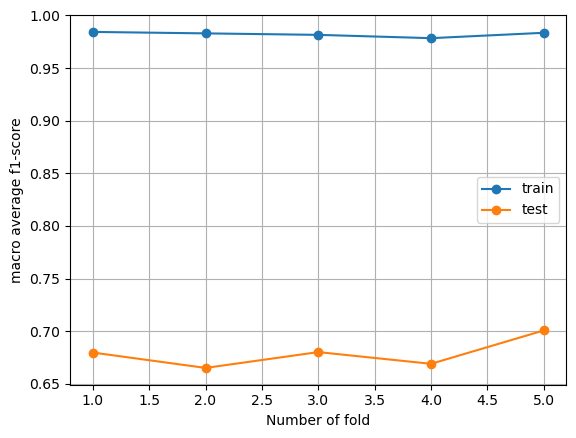

In [43]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='C0', label='train')
plt.plot(folds, performance_test, 'o-', color='C1', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('macro average f1-score')
plt.show()

In [44]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

print(classification_report(y_test, preds_y_test_inverse))

                            precision    recall  f1-score   support

   Blister and Insert Card       0.68      0.75      0.71      1749
  Blister and sealed blist       0.66      0.46      0.54      1582
            Book packaging       0.80      0.20      0.32        20
Cardb. Sleeve w - w/o Shr.       0.17      0.30      0.22       135
  Cardboard hanger w/o bag       0.35      0.26      0.30        80
    Carton cover (Lid box)       0.41      0.24      0.30       130
   Carton tube with or w/o       0.72      0.65      0.68        20
                      Case       0.32      0.55      0.40        97
         Corrugated carton       0.60      0.53      0.57       774
        Countertop display       0.29      0.50      0.37        30
                  Envelope       0.41      0.76      0.53        59
          Fabric packaging       0.87      0.65      0.74        20
            Folding carton       0.61      0.68      0.65      1644
              Hanger/ Clip       0.89      0.69

### Deeper analysis of DecisionTreeClassifier

In [45]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Corrugated carton,Folding carton,1.000000
1,Tube,Tube,1.000000
2,Tube,Tube,1.000000
3,Plastic Box,Plastic Box,1.000000
4,Hanger/ Clip,Hanger/ Clip,1.000000
5,Blister and sealed blist,Corrugated carton,1.000000
6,Blister and Insert Card,Blister and Insert Card,1.000000
7,TightPack,TightPack,1.000000
8,Blister and Insert Card,Blister and sealed blist,1.000000
9,Tube,Tube,1.000000


In [46]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test


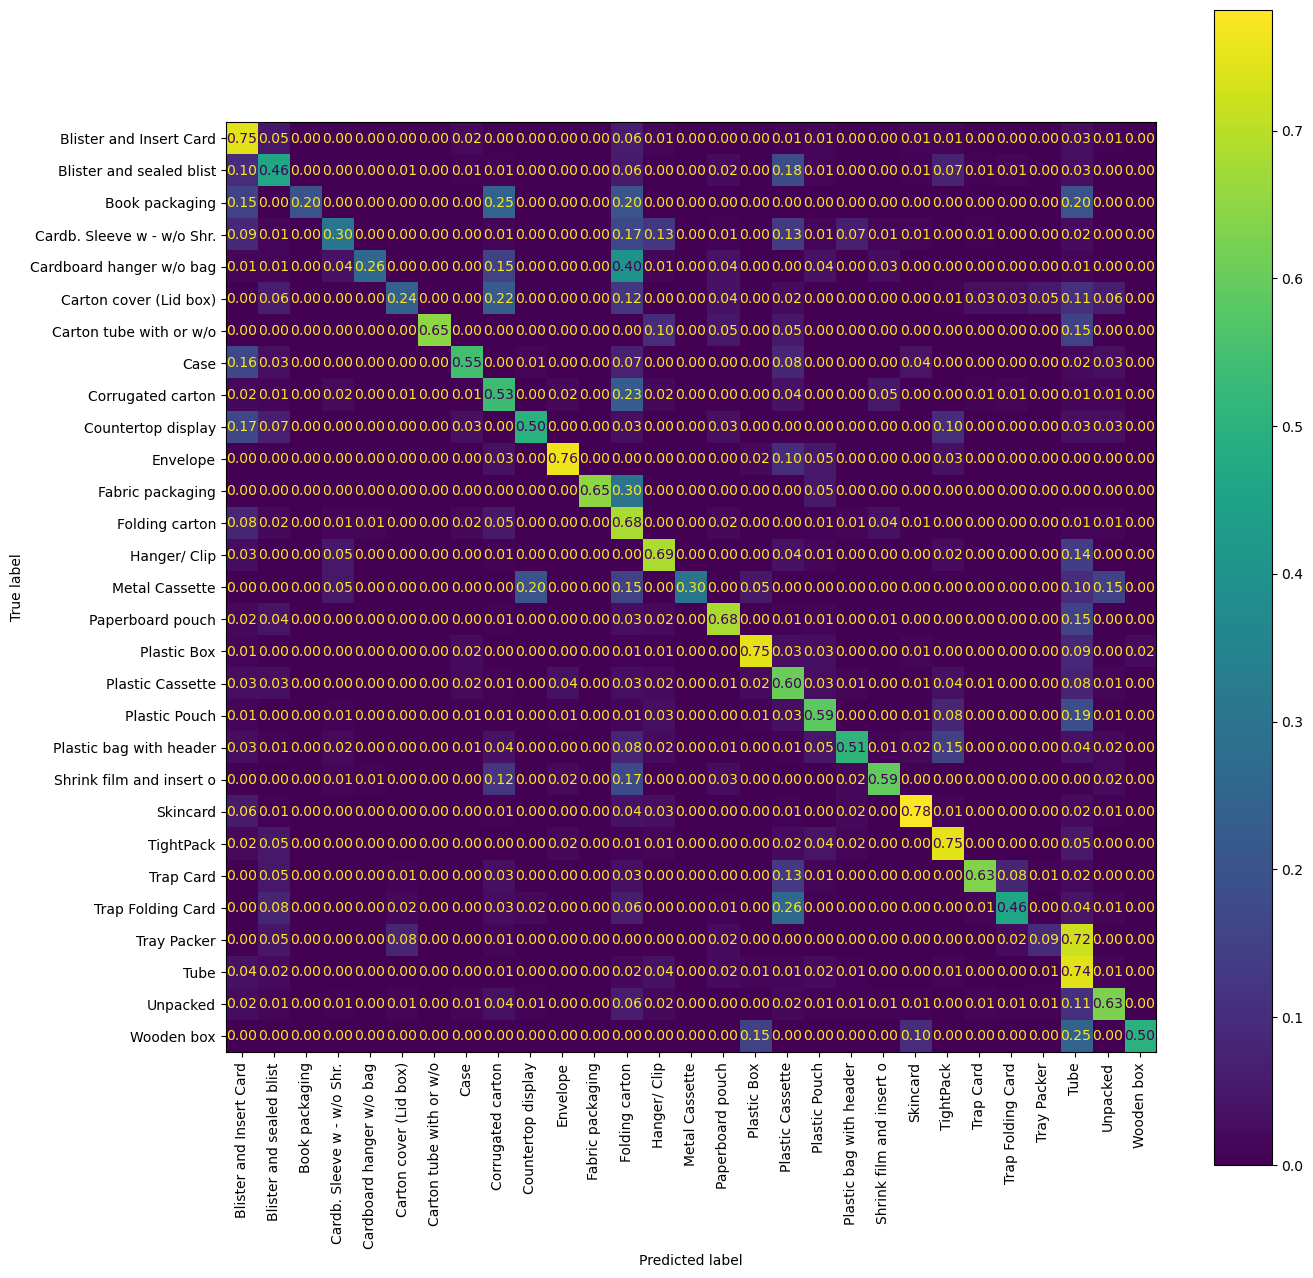

In [47]:
# Create the confusion matrix
# confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

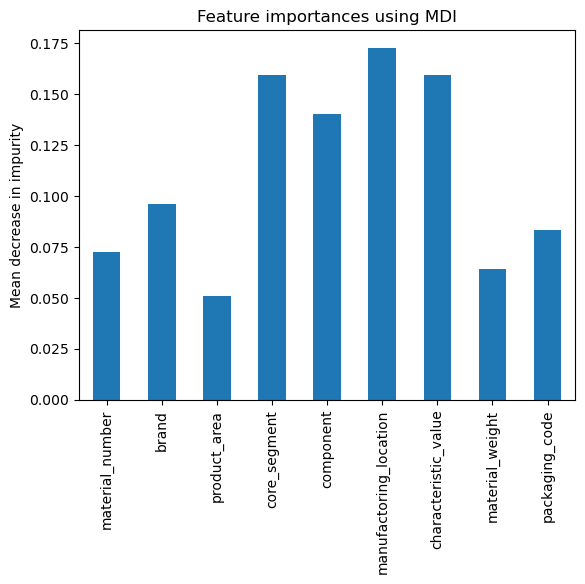

In [48]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# Threshold analysis best model

Findings threshold analysis: since the decision tree does not provide probabilty a threshold analysis does not make any sense

In [49]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Corrugated carton,Folding carton,1.000000
1,Tube,Tube,1.000000
2,Tube,Tube,1.000000
3,Plastic Box,Plastic Box,1.000000
4,Hanger/ Clip,Hanger/ Clip,1.000000
5,Blister and sealed blist,Corrugated carton,1.000000
6,Blister and Insert Card,Blister and Insert Card,1.000000
7,TightPack,TightPack,1.000000
8,Blister and Insert Card,Blister and sealed blist,1.000000
9,Tube,Tube,1.000000


In [50]:
df_y_test_threshold = df_y_test.copy()
df_y_test_threshold.head()

,y_test,preds_y_test,proba_preds_y_test
0,Corrugated carton,Folding carton,1.0
1,Tube,Tube,1.0
2,Tube,Tube,1.0
3,Plastic Box,Plastic Box,1.0
4,Hanger/ Clip,Hanger/ Clip,1.0


In [51]:
# threshhold None
df_y_test_threshold_X = df_y_test_threshold.copy()

def custom_class_report(y_true, y_preds):
    report = classification_report(y_true, y_preds, output_dict=True)
    print(classification_report(y_true, y_preds))
    return report

rf_clf_classification_report = custom_class_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test)

                            precision    recall  f1-score   support

   Blister and Insert Card       0.68      0.75      0.71      1749
  Blister and sealed blist       0.66      0.46      0.54      1582
            Book packaging       0.80      0.20      0.32        20
Cardb. Sleeve w - w/o Shr.       0.17      0.30      0.22       135
  Cardboard hanger w/o bag       0.35      0.26      0.30        80
    Carton cover (Lid box)       0.41      0.24      0.30       130
   Carton tube with or w/o       0.72      0.65      0.68        20
                      Case       0.32      0.55      0.40        97
         Corrugated carton       0.60      0.53      0.57       774
        Countertop display       0.29      0.50      0.37        30
                  Envelope       0.41      0.76      0.53        59
          Fabric packaging       0.87      0.65      0.74        20
            Folding carton       0.61      0.68      0.65      1644
              Hanger/ Clip       0.89      0.69

In [52]:
# threshhold 95
df_y_test_threshold_X = df_y_test_threshold.loc[
    df_y_test_threshold.proba_preds_y_test >= 0.95
]

def custom_class_report(y_true, y_preds):
    report = classification_report(y_true, y_preds, output_dict=True)
    print(classification_report(y_true, y_preds))
    return report

rf_clf_classification_report = custom_class_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test)

                            precision    recall  f1-score   support

   Blister and Insert Card       0.69      0.75      0.72      1715
  Blister and sealed blist       0.66      0.46      0.54      1551
            Book packaging       0.80      0.20      0.32        20
Cardb. Sleeve w - w/o Shr.       0.17      0.30      0.22       131
  Cardboard hanger w/o bag       0.35      0.28      0.31        71
    Carton cover (Lid box)       0.41      0.24      0.30       130
   Carton tube with or w/o       0.72      0.65      0.68        20
                      Case       0.32      0.55      0.40        96
         Corrugated carton       0.62      0.53      0.57       751
        Countertop display       0.29      0.50      0.37        30
                  Envelope       0.41      0.78      0.54        58
          Fabric packaging       0.87      0.65      0.74        20
            Folding carton       0.61      0.68      0.64      1581
              Hanger/ Clip       0.89      0.69